In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os.path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def print_data_analysis(present_lighting_sufficient_data, 
                        present_lighting_insufficient_data, 
                        not_present_lighting_sufficient_data, 
                        not_present_lighting_insufficient_data):
  
    subplot = plt.subplot()
    data_lengthes = np.array([
        [len(present_lighting_sufficient_data), len(present_lighting_insufficient_data)], 
        [len(not_present_lighting_sufficient_data), len(not_present_lighting_insufficient_data)]
    ])
    sns.heatmap(data_lengthes, annot=True, fmt='g', cmap='Blues')
    subplot.xaxis.set_ticklabels(['Lighting Sufficient', 'Lighting Not Sufficient'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(file_path)
    return transform(image)

def get_data_and_labels(directory_path, label):
    image_tensors, labels = [], []
    for file in os.listdir(directory_path):
        if file.endswith(".JPG"):
            file_path = directory_path + file
            image_tensor = get_image_tensor(file_path)

            image_tensors.append(image_tensor)
            labels.append(label)
            
    return image_tensors, labels

def get_data_for_label(file_pathes, label): 

  all_data, all_labels = [], []
  for file_path in file_pathes:
      data, labels = get_data_and_labels(file_path, label)
      all_data.extend(data)
      all_labels.extend(labels)

  return all_data, all_labels
    
def get_data_sets(present_file_pathes_lighting_sufficient, 
                  present_file_pathes_lighting_insufficient,
                  not_present_file_pathes_lighting_sufficient,
                  not_present_file_pathes_lighting_insufficient): 

    present_ls_data, present_ls_labels = get_data_for_label(present_file_pathes_lighting_sufficient, 1)
    present_lis_data, present_lis_labels = get_data_for_label(present_file_pathes_lighting_insufficient, 1)
    not_present_ls_data, not_present_ls_labels = get_data_for_label(not_present_file_pathes_lighting_sufficient, 0)
    not_present_lis_data, not_present_lis_labels = get_data_for_label(not_present_file_pathes_lighting_insufficient, 0)

    print_data_analysis(present_ls_data, present_lis_data, not_present_ls_data, not_present_lis_data)
    
    ls_data = present_ls_data + not_present_ls_data
    ls_labels = present_ls_labels + not_present_ls_labels

    lis_data = present_lis_data + not_present_lis_data
    lis_labels = present_lis_labels + not_present_lis_labels
    
    ls_training_data, ls_testing_data, ls_training_labels, ls_testing_labels = train_test_split(ls_data, ls_labels)
    lis_training_data, lis_testing_data, lis_training_labels, lis_testing_labels = train_test_split(lis_data, lis_labels)

    training_data = ls_training_data + lis_training_data
    testing_data = ls_testing_data + lis_testing_data
    training_labels = ls_training_labels + lis_training_labels
    testing_labels = ls_testing_labels + lis_testing_labels
    
    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    print("Number of lighting sufficient testing photos: " + str(len(ls_testing_data)))
    print("Number of lighting insufficient testing photos: " + str(len(lis_testing_data)))
    
    training_data_set = image_data_set(training_data, training_labels)
    testing_data_set = image_data_set(testing_data, testing_labels)
    ls_testing_data_set = image_data_set(ls_testing_data, ls_testing_labels)
    lis_testing_data_set = image_data_set(lis_testing_data, lis_testing_labels)
    
    return training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set

def get_loaders(training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data_set,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    ls_testing_loader = torch.utils.data.DataLoader(dataset = ls_testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    lis_testing_loader = torch.utils.data.DataLoader(dataset = lis_testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader, ls_testing_loader, lis_testing_loader

In [4]:
def get_batch_data_and_labels(directory_path, label):
    all_image_tensors, all_labels = [], []
    for folder in os.listdir(directory_path):
        new_directory_path = str(directory_path + folder)
        if(os.path.isdir(new_directory_path)):
            batch_image_tensors = []
            for file in os.listdir(new_directory_path):
                if file.endswith(".JPG"):
                    file_path = new_directory_path + "/" + file
                    image_tensor = get_image_tensor(file_path)
                    batch_image_tensors.append(image_tensor)
            stacked_tensor = torch.stack(batch_image_tensors)
            all_image_tensors.append(stacked_tensor)   
            all_labels.append(label)  
    return all_image_tensors, all_labels

def get_batch_data_for_label(file_pathes, label): 

  all_data, all_labels = [], []
  for file_path in file_pathes:
      data, labels = get_batch_data_and_labels(file_path, label)
      all_data.extend(data)
      all_labels.extend(labels)

  return all_data, all_labels

def get_batch_data_sets(present_file_pathes_lighting_sufficient, 
                        present_file_pathes_lighting_insufficient,
                        not_present_file_pathes_lighting_sufficient,
                        not_present_file_pathes_lighting_insufficient): 
      
      present_ls_data, present_ls_labels = get_batch_data_for_label(present_file_pathes_lighting_sufficient, 1)
      present_lis_data, present_lis_labels = get_batch_data_for_label(present_file_pathes_lighting_insufficient, 1)
      not_present_ls_data, not_present_ls_labels = get_batch_data_for_label(not_present_file_pathes_lighting_sufficient, 0)
      not_present_lis_data, not_present_lis_labels = get_batch_data_for_label(not_present_file_pathes_lighting_insufficient, 0)

      ls_data = present_ls_data + not_present_ls_data
      ls_labels = present_ls_labels + not_present_ls_labels

      lis_data = present_lis_data + not_present_lis_data
      lis_labels = present_lis_labels + not_present_lis_labels

      testing_data = ls_data + lis_data
      testing_labels = ls_labels + lis_labels

      testing_data_set = image_data_set(testing_data, testing_labels)
      ls_testing_data_set = image_data_set(ls_data, ls_labels)
      lis_testing_data_set = image_data_set(lis_data, lis_labels)
    
      return testing_data_set, ls_testing_data_set, lis_testing_data_set

In [5]:
def print_image(image_tensor, prediction):
    if(prediction == 1):
        prediction_string = "Wildlife Present"
    else:
        prediction_string = "No Wildlife Present"

    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + prediction_string) 
    plt.show()

def print_testing_analysis(all_labels, all_predictions, title):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[1, 0])
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        for index, prediction in enumerate(predictions):
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction)

        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())
    
    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

def test_batch(model, testing_data_set, criterion, print_incorrect_images):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_data_set):
        data, label = data['data'].to(device), data['label']

        output = model(data)
        #loss = criterion(output, labels)
        #running_loss += loss.item()

        _, predictions = torch.max(output.data, 1)

        batch_prediction = 0
        for single_prediction in predictions:
            if(single_prediction == 1):
                batch_prediction = 1   

        if(batch_prediction == label):
            num_correct += 1

        all_labels.append(label)
        all_predictions.append(batch_prediction)
    
    loss = running_loss/len(testing_data_set)
    accuracy = num_correct/len(testing_data_set)
    return loss, accuracy, all_labels, all_predictions

In [6]:
def train_and_test(model, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, batch_testing_data_set, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(5):
        print("epoch: " + str(epoch))
        
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))
        
        testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

    testing_loss, testing_accuracy, labels, predictions = test(model, testing_loader, criterion, True)
    print_testing_analysis(labels, predictions, "Overall")

    testing_loss, testing_accuracy, labels, predictions = test(model, ls_testing_loader, criterion, False)
    print_testing_analysis(labels, predictions, "Lighting Sufficient")

    testing_loss, testing_accuracy, labels, predictions = test(model, lis_testing_loader, criterion, False)
    print_testing_analysis(labels, predictions, "Lighting Insufficient")

    batch_testing_loss, batch_testing_accuracy, batch_labels, batch_predictions = test_batch(model, batch_testing_data_set, criterion, False)
    print_testing_analysis(batch_labels, batch_predictions, "Batch Resnet50")

In [13]:
def train_and_test_ResNet50(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, batch_testing_data_set, device, num_classes):
    print("\nTraining and Testing ResNet50")
    resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    resnet50.fc.out_features = num_classes
    train_and_test(resnet50, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, batch_testing_data_set, device)

def train_and_test_ResNet152(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, batch_testing_data_set, device, num_classes):
    print("\nTraining and Testing ResNet152")
    resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
    resnet152.fc.out_features = num_classes
    train_and_test(resnet152, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, batch_testing_data_set, device)

def train_and_test_ViT_L_16(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing Vision Transformer Large 16")
    vit_l_16 = models.vit_l_16(weights = models.ViT_L_16_Weights.IMAGENET1K_V1)
    train_and_test(vit_l_16, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

#Orchestration

In [8]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip -qq drive/MyDrive/manually_labeled_wildlife_data
!unzip -qq drive/MyDrive/batch_manually_labeled_wildlife_data

Mounted at /content/drive


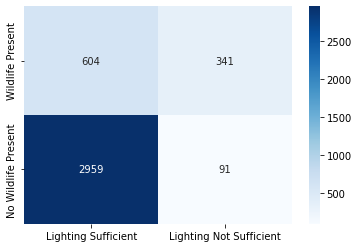


Number of training photos: 2996
Number of testing photos: 999
Number of lighting sufficient testing photos: 891
Number of lighting insufficient testing photos: 108


In [9]:
present_file_pathes_ls = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/lighting_sufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/present/lighting_sufficient/"
]

present_file_pathes_lis = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/lighting_insufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/present/lighting_insufficient/"
]

not_present_file_pathes_ls = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/lighting_sufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/lighting_sufficient/",
]

not_present_file_pathes_lis = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/lighting_insufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/lighting_insufficient/",
]

num_classes = 2
batch_size = 10

training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set = get_data_sets(
    present_file_pathes_ls, 
    present_file_pathes_lis,
    not_present_file_pathes_ls,
    not_present_file_pathes_lis
)
training_loader, testing_loader, ls_testing_loader, lis_testing_loader = get_loaders(
    training_data_set, 
    testing_data_set, 
    ls_testing_data_set, 
    lis_testing_data_set, 
    batch_size
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [10]:
batch_present_file_pathes_ls = [
  "batch_manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/lighting_sufficient/"
]

batch_present_file_pathes_lis = [
  "batch_manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/lighting_insufficient/"
]

batch_not_present_file_pathes_ls = [
  "batch_manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/lighting_sufficient/"
]

batch_not_present_file_pathes_lis = [
  "batch_manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/lighting_insufficient/"
]

batch_testing_data_set, batch_ls_testing_data_set, batch_lis_testing_data_set = get_batch_data_sets(
    batch_present_file_pathes_ls, 
    batch_present_file_pathes_lis,
    batch_not_present_file_pathes_ls,
    batch_not_present_file_pathes_lis
)


Training and Testing ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
training loss: 0.06569443297670664 and training accuracy: 0.8741655540720962
testing loss: 0.01624275763259009 and testing accuracy: 0.9479479479479479
epoch: 1
training loss: 0.01082621274202955 and training accuracy: 0.9549399198931909
testing loss: 0.01358623763006106 and testing accuracy: 0.95995995995996
epoch: 2
training loss: 0.006300623049359279 and training accuracy: 0.9776368491321762
testing loss: 0.006047886028816855 and testing accuracy: 0.9769769769769769
epoch: 3
training loss: 0.004070661104421314 and training accuracy: 0.9839786381842457
testing loss: 0.006171920911284971 and testing accuracy: 0.9769769769769769
epoch: 4
training loss: 0.003817068365339105 and training accuracy: 0.9856475300400535
testing loss: 0.008210738118550553 and testing accuracy: 0.96996996996997


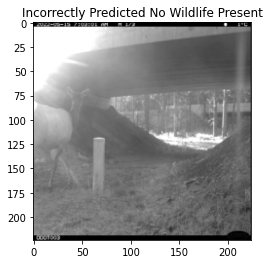

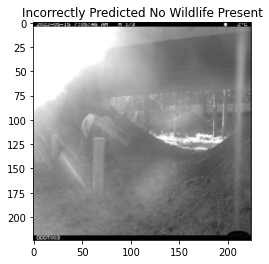

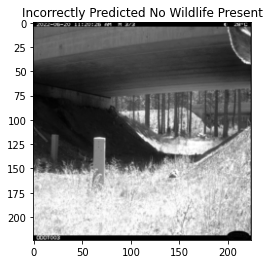

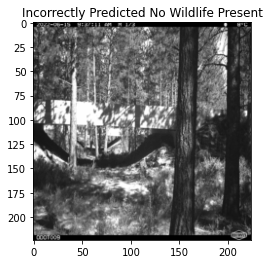

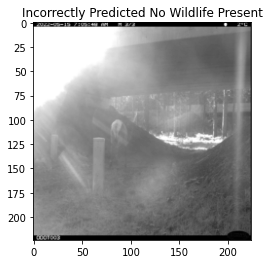

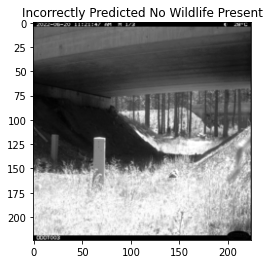

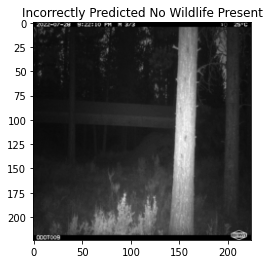

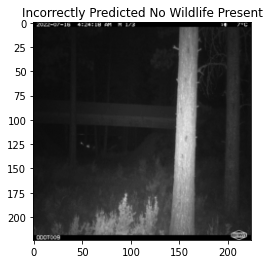

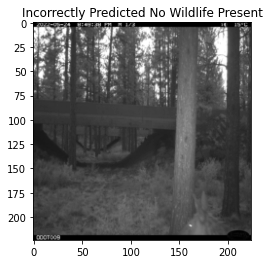

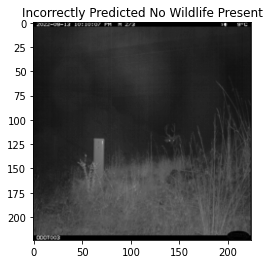

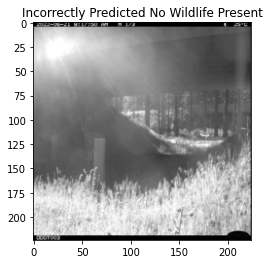

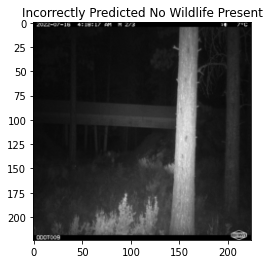

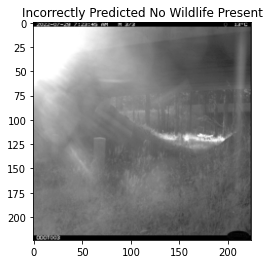

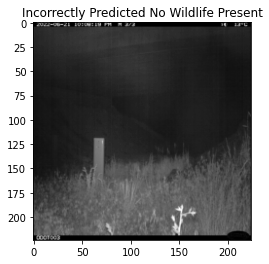

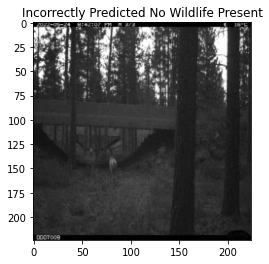

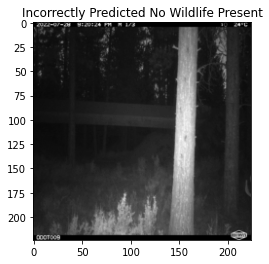

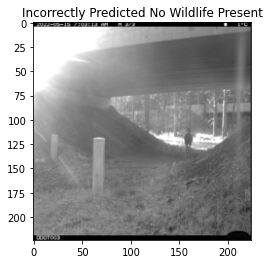

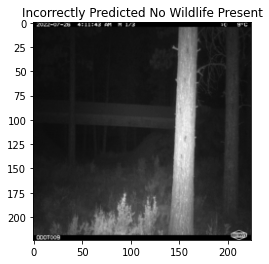

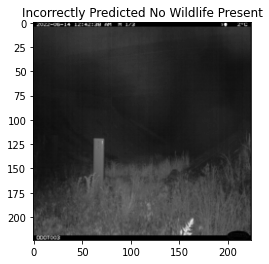

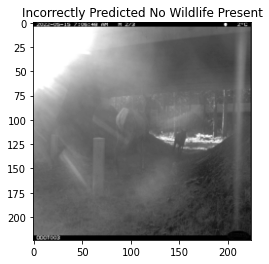

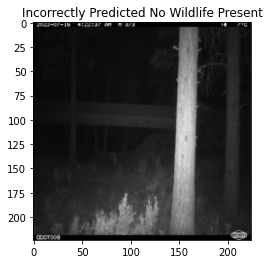

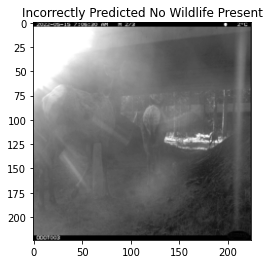

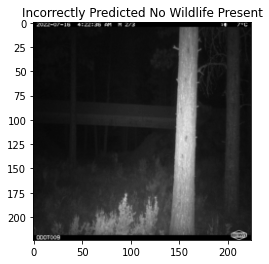

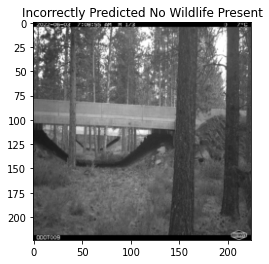

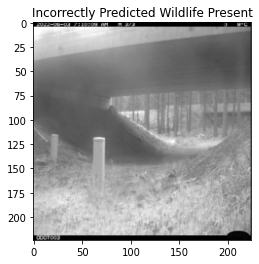

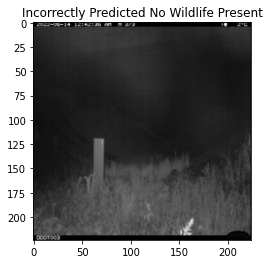

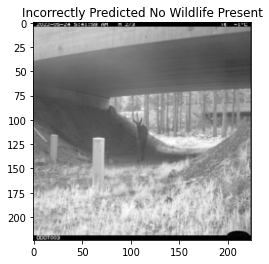

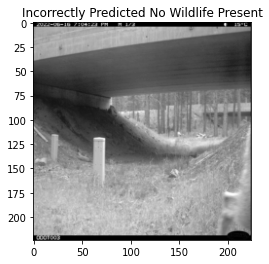

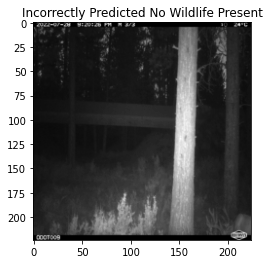

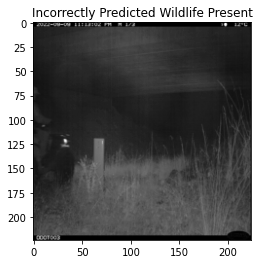

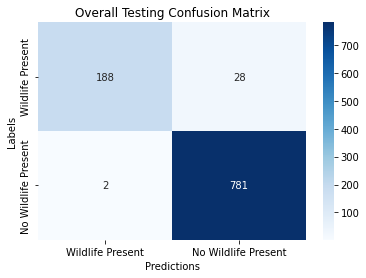

Overall Accuracy: 0.96996996996997
Overall Precision: 0.9894736842105263
Overall Recall: 0.8703703703703703
Overall F-Score: 0.9261083743842365


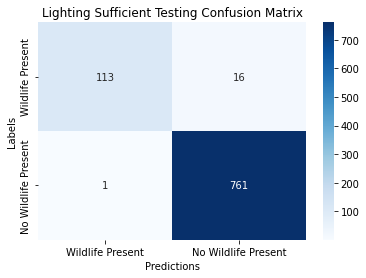

Lighting Sufficient Accuracy: 0.9809203142536476
Lighting Sufficient Precision: 0.9912280701754386
Lighting Sufficient Recall: 0.875968992248062
Lighting Sufficient F-Score: 0.9300411522633745


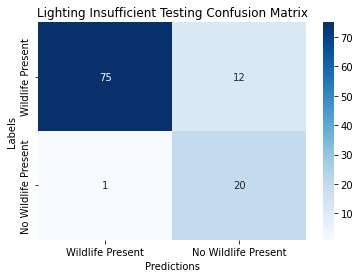

Lighting Insufficient Accuracy: 0.8796296296296297
Lighting Insufficient Precision: 0.9868421052631579
Lighting Insufficient Recall: 0.8620689655172413
Lighting Insufficient F-Score: 0.9202453987730062


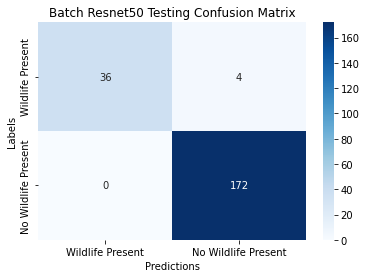

Batch Resnet50 Accuracy: 0.9811320754716981
Batch Resnet50 Precision: 1.0
Batch Resnet50 Recall: 0.9
Batch Resnet50 F-Score: 0.9473684210526316


In [11]:
train_and_test_ResNet50(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, batch_testing_data_set, device, num_classes)


Training and Testing ResNet152


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch: 0
training loss: 0.055862287280755304 and training accuracy: 0.8768357810413885
testing loss: 0.010869817023311888 and testing accuracy: 0.95995995995996
epoch: 1
training loss: 0.01022616014237676 and training accuracy: 0.959279038718291
testing loss: 0.007666815430983095 and testing accuracy: 0.9719719719719719
epoch: 2
training loss: 0.006590470185748007 and training accuracy: 0.9732977303070761
testing loss: 0.0069695822676658645 and testing accuracy: 0.975975975975976
epoch: 3
training loss: 0.005387177470865462 and training accuracy: 0.9786381842456608
testing loss: 0.005567927081218302 and testing accuracy: 0.982982982982983
epoch: 4
training loss: 0.003906749488515963 and training accuracy: 0.9846461949265688
testing loss: 0.004421093345085323 and testing accuracy: 0.9819819819819819


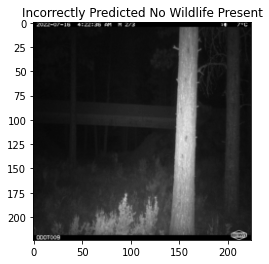

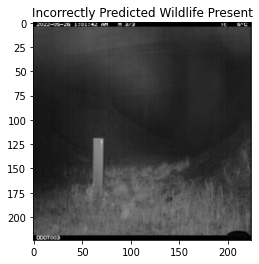

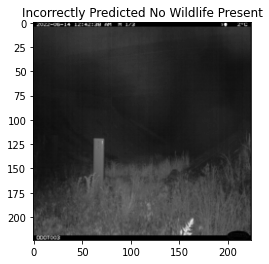

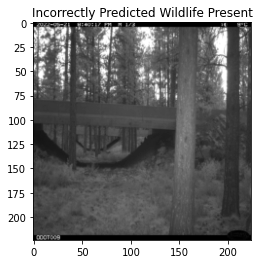

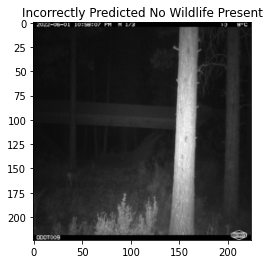

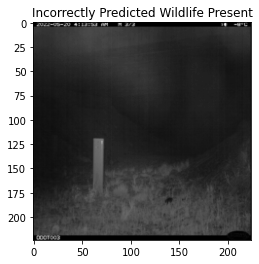

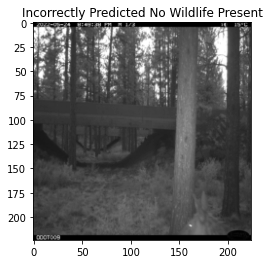

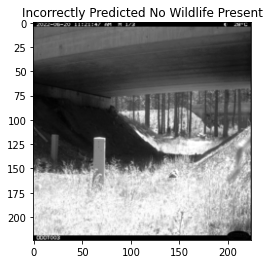

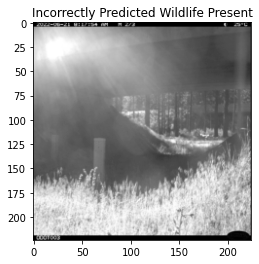

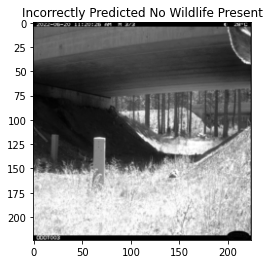

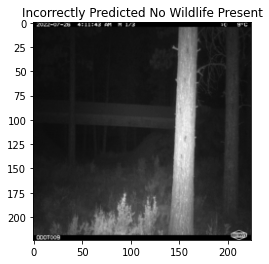

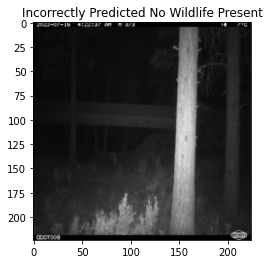

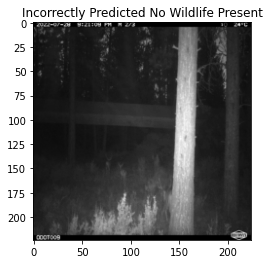

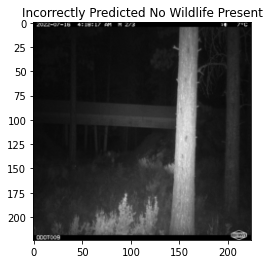

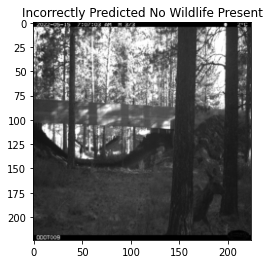

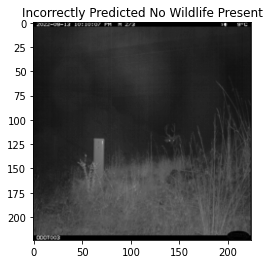

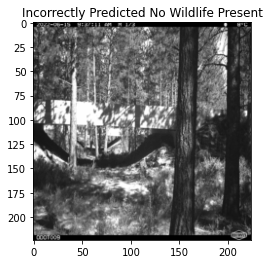

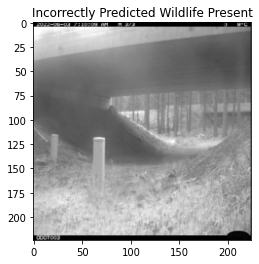

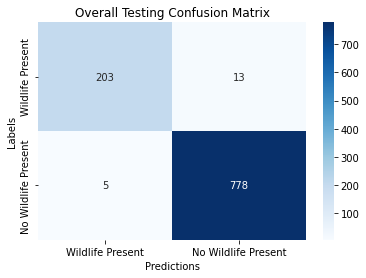

Overall Accuracy: 0.9819819819819819
Overall Precision: 0.9759615384615384
Overall Recall: 0.9398148148148148
Overall F-Score: 0.9575471698113207


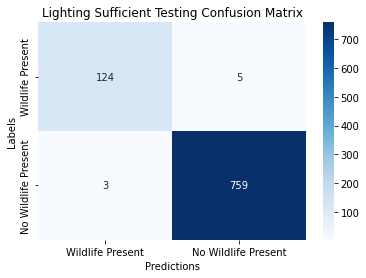

Lighting Sufficient Accuracy: 0.9910213243546577
Lighting Sufficient Precision: 0.9763779527559056
Lighting Sufficient Recall: 0.9612403100775194
Lighting Sufficient F-Score: 0.9687500000000001


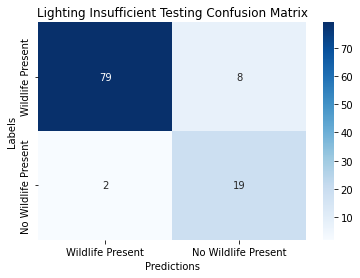

Lighting Insufficient Accuracy: 0.9074074074074074
Lighting Insufficient Precision: 0.9753086419753086
Lighting Insufficient Recall: 0.9080459770114943
Lighting Insufficient F-Score: 0.9404761904761905


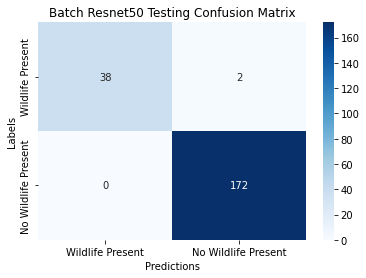

Batch Resnet50 Accuracy: 0.9905660377358491
Batch Resnet50 Precision: 1.0
Batch Resnet50 Recall: 0.95
Batch Resnet50 F-Score: 0.9743589743589743


In [14]:
train_and_test_ResNet152(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, batch_testing_data_set, device, num_classes)